<a href="https://colab.research.google.com/github/kachytronico/colab-PIA/blob/main/303_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje **NO** supervisado: DBScan

Durante este cuadernillo veremos la técnica de DBScan, perteneciente al grupo de aprendizaje **NO** supervisado.

Recuerda que este tipo de aprendizaje nos permite separar nuestro conjunto de datos en distintos grupos (se llaman _técnicas de agrupación_).

## Introducción teórica

El algoritmo _DBScan_ analiza la densidad de los puntos cercanos para cada punto de nuestro conjunto de datos. En particular, añade puntos a un grupo si está próximo a otro punto de ese grupo.

Una de las mayores ventajas de este modelo es que puede detectar los _outliers_ por sí solo.

Veamos cómo se utiliza. [Aquí](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/) tienes una forma muy visual que lo ejemplifica.

## Uso computacional

Vamos a ver ahora cómo podemos utilizar este algoritmo. El conjunto de datos que usaremos será el conjunto _taxis_ de _seaborn_.

## Limpieza de datos

Aplico todas las técnicas de limpieza vistas en el tema 2.

**OBJETIVO**: ¿hay distintos tipos de clientes en la ciudad de Manhattan? Si fuera un taxista, ¿a dónde iría a por mis clientes?

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import math

In [ ]:
df = sns.load_dataset("taxis", cache=False)
df

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,East Harlem North,Central Harlem North,Manhattan,Manhattan
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,Jamaica,East Concourse/Concourse Village,Queens,Bronx
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,Crown Heights North,Bushwick North,Brooklyn,Brooklyn
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,East New York,East Flatbush/Remsen Village,Brooklyn,Brooklyn


### Grupo de entrenamiento y de testeo

En un problema de aprendizaje **NO** supervisado **NO** tiene sentido dividir el conjunto de entrenamiento.

### Eliminación de columnas inútiles, valores sin sentido y atípicos

Elimino todas las columnas que no sean relevantes para los clientes de la ciudad de Manhattan.

En particular, me quedo con la columna ```pickup_zone``` que me permite saber la zona (imprescindible para mi problema).

In [ ]:
df = df.drop(columns=["pickup", "dropoff", "passengers", "color", "dropoff_zone", "dropoff_borough"])
df = df[df.pickup_borough == "Manhattan"]
df

,distance,fare,tip,tolls,total,payment,pickup_zone,pickup_borough
0,1.60,7.0,2.15,0.0,12.95,credit card,Lenox Hill West,Manhattan
1,0.79,5.0,0.00,0.0,9.30,cash,Upper West Side South,Manhattan
2,1.37,7.5,2.36,0.0,14.16,credit card,Alphabet City,Manhattan
3,7.70,27.0,6.15,0.0,36.95,credit card,Hudson Sq,Manhattan
4,2.16,9.0,1.10,0.0,13.40,credit card,Midtown East,Manhattan
...,...,...,...,...,...,...,...,...
6420,1.20,7.0,0.00,0.0,7.80,cash,Central Harlem,Manhattan
6422,4.02,16.0,0.00,0.0,17.30,cash,Washington Heights South,Manhattan
6424,1.70,8.0,0.00,0.0,9.30,cash,Central Harlem,Manhattan
6426,0.71,4.5,0.50,0.0,5.80,credit card,Central Park,Manhattan


Al haber reducido así nuestro conjunto de datos, tenemos columnas con muy poca variabilidad. Las dejo para eliminarlas en el análisis de variabilidad como ejemplo.

In [ ]:
df.describe()

,distance,fare,tip,tolls,total
count,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000
mean,2.349723,11.152889,1.939550,0.142912,16.670507
std,2.668469,8.239970,2.023955,0.943482,10.079846
min,0.000000,2.500000,0.000000,0.000000,3.300000
25%,0.930000,6.000000,0.000000,0.000000,11.000000
50%,1.500000,8.500000,1.860000,0.000000,13.800000
75%,2.630000,13.000000,2.800000,0.000000,18.960000
max,28.300000,130.000000,20.560000,17.280000,136.560000


```distance``` con valor 0 parece un valor sin sentido. Lo borramos.

In [ ]:
df = df[df.distance != 0]
df.describe()

,distance,fare,tip,tolls,total
count,5253.000000,5253.000000,5253.000000,5253.000000,5253.000000
mean,2.356433,11.132480,1.936461,0.139509,16.644906
std,2.669316,8.167354,2.003231,0.931305,9.965805
min,0.020000,2.500000,0.000000,0.000000,3.300000
25%,0.930000,6.000000,0.000000,0.000000,11.000000
50%,1.500000,8.500000,1.860000,0.000000,13.800000
75%,2.640000,13.000000,2.800000,0.000000,18.960000
max,28.300000,130.000000,20.560000,17.280000,136.560000


Los _outliers_ **NO** los trato para que se vea la utilidad del modelo **DBScan**.

### Datos nulos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5253 entries, 0 to 6428
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distance        5253 non-null   float64
 1   fare            5253 non-null   float64
 2   tip             5253 non-null   float64
 3   tolls           5253 non-null   float64
 4   total           5253 non-null   float64
 5   payment         5224 non-null   object 
 6   pickup_zone     5253 non-null   object 
 7   pickup_borough  5253 non-null   object 
dtypes: float64(5), object(3)
memory usage: 369.4+ KB


Datos nulos:
- 29 filas de ```payment```.

In [ ]:
29 / 5268 * 100

0.5504935459377372

Como es inferior al 5%,  borro esos datos.

In [ ]:
df = df.dropna() # como solo voy a aplicar la técnica de eliminación, puedo usar la función dropna
df

,distance,fare,tip,tolls,total,payment,pickup_zone,pickup_borough
0,1.60,7.0,2.15,0.0,12.95,credit card,Lenox Hill West,Manhattan
1,0.79,5.0,0.00,0.0,9.30,cash,Upper West Side South,Manhattan
2,1.37,7.5,2.36,0.0,14.16,credit card,Alphabet City,Manhattan
3,7.70,27.0,6.15,0.0,36.95,credit card,Hudson Sq,Manhattan
4,2.16,9.0,1.10,0.0,13.40,credit card,Midtown East,Manhattan
...,...,...,...,...,...,...,...,...
6420,1.20,7.0,0.00,0.0,7.80,cash,Central Harlem,Manhattan
6422,4.02,16.0,0.00,0.0,17.30,cash,Washington Heights South,Manhattan
6424,1.70,8.0,0.00,0.0,9.30,cash,Central Harlem,Manhattan
6426,0.71,4.5,0.50,0.0,5.80,credit card,Central Park,Manhattan


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5224 entries, 0 to 6428
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distance        5224 non-null   float64
 1   fare            5224 non-null   float64
 2   tip             5224 non-null   float64
 3   tolls           5224 non-null   float64
 4   total           5224 non-null   float64
 5   payment         5224 non-null   object 
 6   pickup_zone     5224 non-null   object 
 7   pickup_borough  5224 non-null   object 
dtypes: float64(5), object(3)
memory usage: 367.3+ KB


### Variabilidad

#### Columnas categóricas

In [ ]:
def categorical_variability(df, threshold: float = 0.2): # threshold > 0.33 no tiene sentido para binarias
  categorical_df = df.select_dtypes(exclude="number")
  threshold *= len(df) # obtengo el threshold absoluto

  for column in categorical_df.columns:
    serie = categorical_df[column].value_counts()
    n_categories = len(serie)
    non_variability = serie[0] - sum(serie[1:])
    if n_categories == 1 or (n_categories == 2 and non_variability > threshold * 3) or (n_categories > 2 and non_variability > threshold):
      print(f"Cuidado, la columna {column} tiene una NO variabilidad de {non_variability}, que supera el threshold establecido.")

In [ ]:
categorical_variability(df)

Cuidado, la columna pickup_borough tiene una NO variabilidad de 5224, que supera el threshold establecido.


/tmp/ipython-input-2891938529.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_variability = serie[0] - sum(serie[1:])
/tmp/ipython-input-2891938529.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_variability = serie[0] - sum(serie[1:])
/tmp/ipython-input-2891938529.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_variability = serie[0] - sum(serie[1:])


Claramente, la columna ```pickup_borough``` ahora solo tiene el valor ```Manhattan```, así que tiene sentido eliminarla.

In [ ]:
df = df.drop(columns="pickup_borough")
df.head()

,distance,fare,tip,tolls,total,payment,pickup_zone
0,1.60,7.0,2.15,0.0,12.95,credit card,Lenox Hill West
1,0.79,5.0,0.00,0.0,9.30,cash,Upper West Side South
2,1.37,7.5,2.36,0.0,14.16,credit card,Alphabet City
3,7.70,27.0,6.15,0.0,36.95,credit card,Hudson Sq
4,2.16,9.0,1.10,0.0,13.40,credit card,Midtown East


#### Columnas numéricas

In [ ]:
def numerical_variability(df, threshold: float = 0.1):
  numerical_df = df.select_dtypes("number")

  for column in numerical_df.columns:
    serie = numerical_df[column].value_counts()
    _max = serie.iloc[0] # primer elemento (el más grande) ; max es una palabra reservada
    prop = _max / len(df) * 100.0 # proportion
    if prop > threshold * 100.0:
      print(f"Cuidado, la proporción de valores idénticos para la columna {column} es de {prop}%, que supera el threshold establecido.")

In [ ]:
numerical_variability(df)

Cuidado, la proporción de valores idénticos para la columna tip es de 29.78560490045942%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna tolls es de 97.64548238897397%, que supera el threshold establecido.


Que coincida la columna ```tip``` es muy extraño, pero considero que esta columna es fundamental para nuestro análisis.

La columna ```tolls``` la podemos descartar (extremadamente poco variable).

In [ ]:
df = df.drop(columns="tolls")
df.head()

,distance,fare,tip,total,payment,pickup_zone
0,1.60,7.0,2.15,12.95,credit card,Lenox Hill West
1,0.79,5.0,0.00,9.30,cash,Upper West Side South
2,1.37,7.5,2.36,14.16,credit card,Alphabet City
3,7.70,27.0,6.15,36.95,credit card,Hudson Sq
4,2.16,9.0,1.10,13.40,credit card,Midtown East


### Columnas categóricas

Tenemos dos variables categóricas (```payment``` y ```pickup_zone```). Sin embargo, no vamos a tratar la columna ```pickup_zone``` dado que no la vamos a utilizar para entrenar nuestro modelo (parece ser justo lo que queremos adivinar, no tiene sentido usarlo para agrupar). En este caso, separaremos esta columna para utilizarla después.

```payment``` solo tiene dos posibles valores, puedo hacer esto a mano.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5224 entries, 0 to 6428
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   distance     5224 non-null   float64
 1   fare         5224 non-null   float64
 2   tip          5224 non-null   float64
 3   total        5224 non-null   float64
 4   payment      5224 non-null   object 
 5   pickup_zone  5224 non-null   object 
dtypes: float64(4), object(2)
memory usage: 285.7+ KB


In [ ]:
df.payment.unique()

array(['credit card', 'cash'], dtype=object)

```payment``` no tiene ningún tipo de orden.

In [ ]:
df["payment_isCash"] = df.payment.apply(lambda e: 1 if e == "cash" else 0)
df = df.drop(columns="payment")

pickup_zone = df.pickup_zone
df = df.drop(columns="pickup_zone")

df.head()

,distance,fare,tip,total,payment_isCash
0,1.60,7.0,2.15,12.95,0
1,0.79,5.0,0.00,9.30,1
2,1.37,7.5,2.36,14.16,0
3,7.70,27.0,6.15,36.95,0
4,2.16,9.0,1.10,13.40,0


### Reducción de la dimensionalidad

No necesito estas estrategias por ahora.

### Análisis de correlación

Recuerda que dos variables correladas podían perjudicar el funcionamiento de nuestros modelos. Veamos si este conjunto de datos tiene alguna.

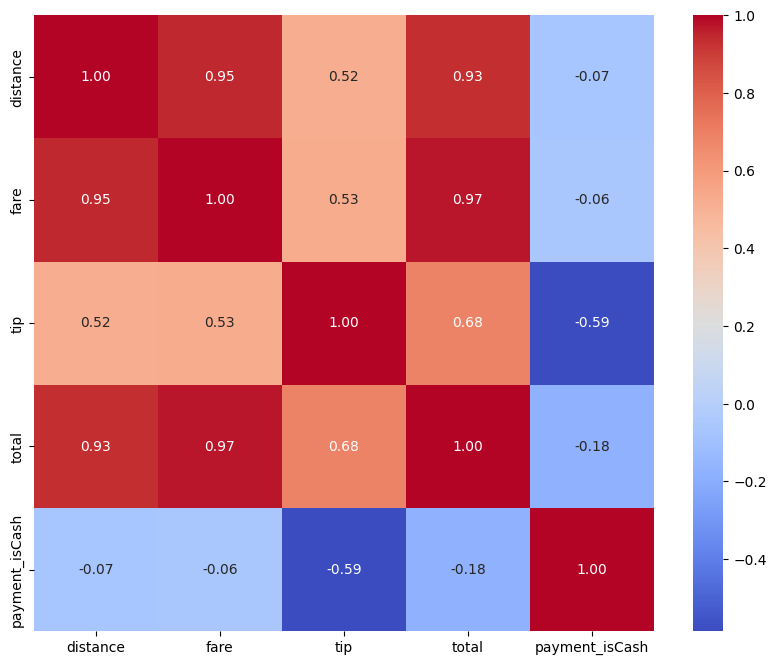

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
plt.show()

```fare``` y ```total``` están muy correladas con ```distance``` y entre ellas, así que borraremos ```total```.

En este caso, vamos a optar por **NO** borrar la columna ```distance``` (te reto a que la borres y veas cómo cambian los resultados --el resto de celdas del cuadernillo deberían funcionar igual--). Esta decisión la tomamos por considerar que ```distance``` es una variable obligatoria para nuestro análisis.

Esta decisión **NO** está bien ni mal, simplemente lo justifico de esta forma porque considero que tendré resultados más valiosos. Tendríamos que probar ambas (yo lo he hecho, jeje; sí estoy haciendo trampa) y decidir la que más nos guste.

In [ ]:
df = df.drop(columns=["total"])
df.head()

,distance,fare,tip,payment_isCash
0,1.60,7.0,2.15,0
1,0.79,5.0,0.00,1
2,1.37,7.5,2.36,0
3,7.70,27.0,6.15,0
4,2.16,9.0,1.10,0


## Aplicación de DBScan

Lo importamos desde ```sklearn```.

In [ ]:
from sklearn.cluster import DBSCAN

random_seed = 33

Creo y entreno mi primer DBScan.

In [ ]:
model = DBSCAN() # DBScan es también un método determinista
pred = model.fit_predict(df)
pred # pred contiene una etiqueta para cada valor

array([0, 1, 0, ..., 1, 0, 0])

Fíjate en que hay valores agrupados con -1. Este grupo especial es el de los valores atípicos (no agrupados por densidad).

Como lo vamos a usar bastante, creo una función para mostrar (y así no duplico código después).

In [ ]:
from sklearn.decomposition import PCA

def show_results(X, y, outliers = True):
  dims = X.shape[1]

  # Si dims > 2 no podemos representarlo sin más. Si supiésemos que dim == 3
  # podríamos usar otras estrategias. Como esta es una función general, optamos
  # por el peor caso.
  if dims > 2:
    pca = PCA(n_components=2)
    X = pca.fit_transform(X) # lo pasamos a 2D

  if not outliers:
    X = X[y != -1]
    y = y[y != -1]

  plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", marker=".")
  plt.title("DBScan")
  plt.xlabel("C1 (característica NO interpretable 1)")
  plt.ylabel("C2 (característica NO interpretable 2)")
  plt.show()

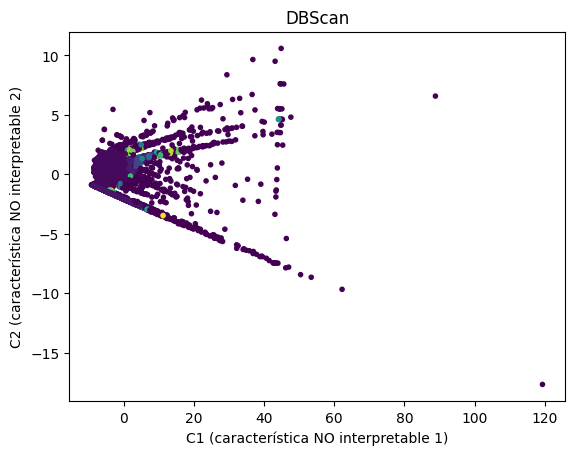

In [ ]:
show_results(df, pred)

Esta versión inicial **NO** me sirve para ver mi resultado. Tengo demasiados valores en morado. He caído en la **maldición de la dimensionalidad**.

Como DBScan usa un **radio** para determinar qué puntos están dentro y cuáles no, la **distancia** entre los puntos es **IMPORTANTÍSIMA** para este modelo.

## Profundización

Los hiperparámetros de DBScan son los siguientes:
- ```eps```: distancia a la que deben estar dos puntos para ser considerados del mismo grupo. **Es el hiperparámetro más importante**.
- ```min_samples```: cantidad mínima de instancias para crear un grupo (define la densidad del grupo de alguna forma).
- ```metric```: la distancia utilizada para medir la separación entre los puntos. Las posibilidades quedan definidas en ```sklearn.metrics.pairwise_distances``` (1).
- ```algorithm```: algoritmo usado en el módulo KNN (2).
- ```p```: la potencia de la métrica (3).
- ```n_jobs```: hilos paralelos utilizados para ejecutar el modelo.

(1). En la siguiente celda se pueden ver todas ellas.

(2). El método KNN lo veremos en el cuadernillo ```305```.

(3). La potencia determina distintas métricas. ```p=1``` es ```Manhattan```, ```p=2``` es ```euclidean```.

In [ ]:
from sklearn.metrics import pairwise_distances

pairwise_distances?

## Optimización

Como hemos visto en ```302``` y en ```303```, vamos a estandarizar nuestro conjunto de datos.

### 1ª idea: estandarizar el conjunto de datos

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
ss = StandardScaler()
standard_df = ss.fit_transform(df) # como no tengo conjunto de testeo, no me preocupo en separar el fit del transform

Ahora entreno con los datos estandarizados

In [ ]:
model = DBSCAN()
pred = model.fit_predict(standard_df)
pred

array([0, 1, 0, ..., 1, 0, 0])

Muestro mis resultados.

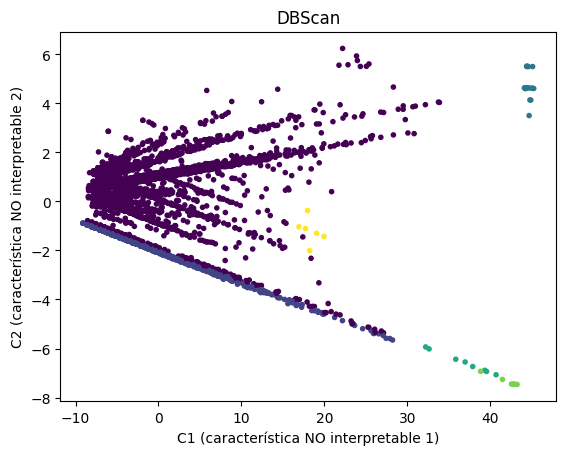

In [ ]:
show_results(df, pred, outliers=False) # NO muestro los datos atípicos. ¡OJO! Uso el df sin estandarizar para mostrar el resultado

Podemos ver el número total de grupos con la longitud de etiquetas únicas.

In [ ]:
len(np.unique(pred)) - 1 # quito los atípicos

6

Con 6 grupos ya podríamos trabajar. Aún así, veamos cómo podemos mejorar nuestro modelo.

### 2ª idea: optimizar el modelo

Durante ```303``` hemos visto la posibilidad de utilizar una búsqueda completa de los hiperparámetros. Sin embargo, hay ocasiones en las que esto no es posible: cuando un hiperparámetro sea numérico, como ```eps```, no podremos buscar todos sus posibles valores (son infinitos).

En estas situaciones, es más útil hacer uso de algoritmos genéticos, pero eso lo dejamos para más tarde. Veamos un ejemplo _un poco pocho_ de cómo solucionarlo.

Vamos a intentar optimizar el valor de ```eps```, el de las instancias mínimas y el de la métrica. Fíjate que tenemos un total de ```6·6·3=108``` combinaciones (108 modelos). Vamos a usar la misma idea que en ```303``` para obtener la mejor.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
best = None

for eps in range(-5, 1):
  eps = 10 ** eps
  for min_samples in range(5, 11):
    for metric in ["l1", "l2", "cosine"]: # las mismas que en 303
      model = DBSCAN(eps=eps, min_samples=min_samples, metric=metric) # el modelo actual
      pred = model.fit_predict(standard_df) # los datos estandarizados
      labels = np.unique(pred)
      n_clusters = len(labels)-1 if -1 in labels else len(labels) # necesito esto para crear el KMeans

      # quito los outliers
      outliers = len(pred[pred == -1])
      no_outliers_df = standard_df[pred != -1]
      no_outliers_pred = pred[pred != -1]

      inertias = []
      for index in range(n_clusters):
        _model = KMeans(n_clusters = 1, n_init="auto") # quiero todos los puntos juntitos
        _model = _model.fit(no_outliers_df[no_outliers_pred == index]) # solo quiero la distancia para los puntos de la clase
        inertias.append(_model.inertia_) # me guardo la inercia

      # simplemente sumo las inercias
      t_inertia = sum(inertias)
      if not best or t_inertia < best:
        print(f"La combinación: eps={eps} - min_samples={min_samples} - metric={metric} es la mejor hasta el momento (con {outliers} outliers).")
        best = t_inertia

La combinación: eps=1e-05 - min_samples=5 - metric=l1 es la mejor hasta el momento (con 5037 outliers).
La combinación: eps=1e-05 - min_samples=5 - metric=l2 es la mejor hasta el momento (con 5037 outliers).
La combinación: eps=1e-05 - min_samples=5 - metric=cosine es la mejor hasta el momento (con 4584 outliers).
La combinación: eps=1e-05 - min_samples=6 - metric=l1 es la mejor hasta el momento (con 5092 outliers).
La combinación: eps=1e-05 - min_samples=6 - metric=l2 es la mejor hasta el momento (con 5092 outliers).
La combinación: eps=1e-05 - min_samples=6 - metric=cosine es la mejor hasta el momento (con 4736 outliers).
La combinación: eps=1e-05 - min_samples=7 - metric=l1 es la mejor hasta el momento (con 5134 outliers).
La combinación: eps=1e-05 - min_samples=7 - metric=l2 es la mejor hasta el momento (con 5134 outliers).
La combinación: eps=1e-05 - min_samples=7 - metric=cosine es la mejor hasta el momento (con 4812 outliers).
La combinación: eps=1e-05 - min_samples=8 - metric=l

La mejor combinación ha sido:
- ```eps``` = ```0.01```.
- ```min_samples``` = ```10``` (el máximo).
- ```metric``` = ```l1``` (manhattan).

Insisto: **cuidado** porque **NO tiene por qué** ser la mejor (hay infinitas combinaciones).

In [ ]:
model = DBSCAN(eps = 0.01, min_samples = 10, metric = "l1")
pred = model.fit_predict(standard_df)

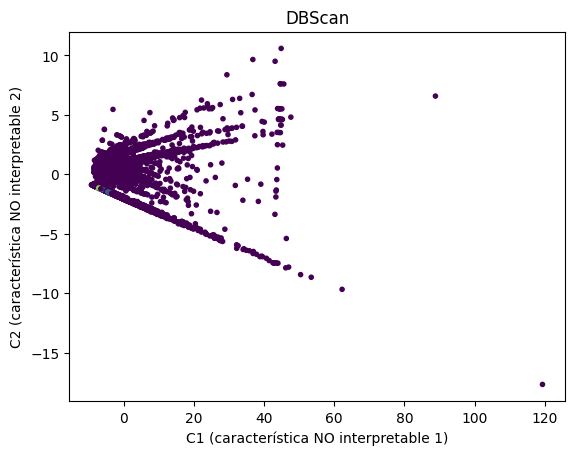

In [ ]:
show_results(df, pred, outliers=True)

Hay muchos datos atípicos, vamos a quitarlos para ver algo.

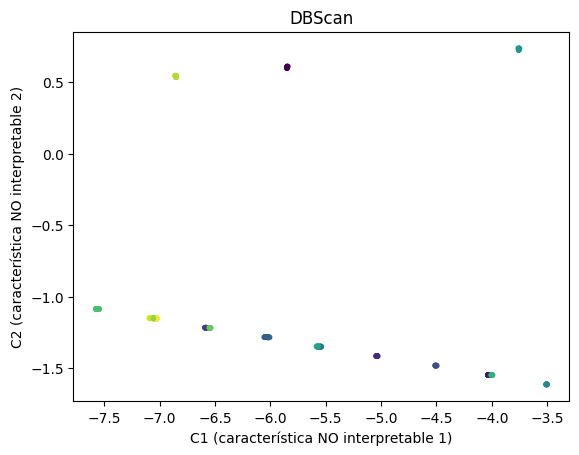

In [ ]:
show_results(df, pred, outliers=False)

**¿¡CÓMO PUEDE HABER TANTOS VALORES ATÍPICOS!?**

Hemos cometido un fallo muy común en el entrenamiento de modelos: hemos **sobreajustado** nuestro modelo.

A veces, al intentar mejorar los modelos que entrenamos, utilizamos hiperparámetros a los que no les importa realmente el modelo. En nuestro caso, hemos tendido a crear grupos muy pequeños considerando que todo es _outlier_. Esto puede estar provocado porque hemos sacado los _outliers_ de nuestra ecuación. Vamos a introducir una penalización por la creación de _outliers_: haremos que un valor atípico pertenezca a todos los grupos a la hora de computar la métrica. De esta forma, al estar muy lejos del **centroide**, perjudicará enormemente esa elección.

Esta decisión de modificar la métrica es **completamente arbitraria**.

In [ ]:
best = None

for eps in range(-5, 2): # he añadido el 1 también aquí, para ver si tenemos mejores resultados
  eps = 10 ** eps
  for min_samples in range(5, 11):
    for metric in ["l1", "l2", "cosine"]: # las mismas que en 303
      model = DBSCAN(eps=eps, min_samples=min_samples, metric=metric) # el modelo actual
      pred = model.fit_predict(standard_df) # los datos estandarizados
      labels = np.unique(pred)
      n_clusters = len(labels)-1 if -1 in labels else len(labels)

      # ya no quito los outliers, simplemente los guardo
      outliers = len(pred[pred == -1])

      inertias = []
      for index in range(n_clusters):
        _model = KMeans(n_clusters = 1, n_init="auto") # quiero todos los puntos juntitos
        _model = _model.fit(standard_df[(pred == index) | (pred == -1)]) # puntos de la clase y ATIPICOS
        inertias.append(_model.inertia_) # me guardo la puntuación

      # simplemente sumo las inercias para este modelo jerárquico
      t_score = sum(inertias) # penalizacion por outliers
      if not best or t_score < best:
        print(f"La combinación: eps={eps} - min_samples={min_samples} - metric={metric} es la mejor hasta el momento (con {outliers} outliers).")
        best = t_score

La combinación: eps=1e-05 - min_samples=5 - metric=l1 es la mejor hasta el momento (con 5037 outliers).
La combinación: eps=1e-05 - min_samples=6 - metric=l1 es la mejor hasta el momento (con 5092 outliers).
La combinación: eps=1e-05 - min_samples=7 - metric=l1 es la mejor hasta el momento (con 5134 outliers).
La combinación: eps=1e-05 - min_samples=8 - metric=l1 es la mejor hasta el momento (con 5155 outliers).
La combinación: eps=1e-05 - min_samples=9 - metric=l1 es la mejor hasta el momento (con 5163 outliers).
La combinación: eps=1e-05 - min_samples=10 - metric=l1 es la mejor hasta el momento (con 5190 outliers).
La combinación: eps=0.01 - min_samples=5 - metric=cosine es la mejor hasta el momento (con 125 outliers).
La combinación: eps=0.01 - min_samples=6 - metric=cosine es la mejor hasta el momento (con 166 outliers).
La combinación: eps=0.01 - min_samples=7 - metric=cosine es la mejor hasta el momento (con 219 outliers).
La combinación: eps=0.01 - min_samples=10 - metric=cosine

Como puede verse, el modelo tiende a elegir modelos con cada vez menos _outliers_. Veamos los mejores resultados.

In [ ]:
model = DBSCAN(eps=1, min_samples=5, metric="l2")
pred = model.fit_predict(standard_df)

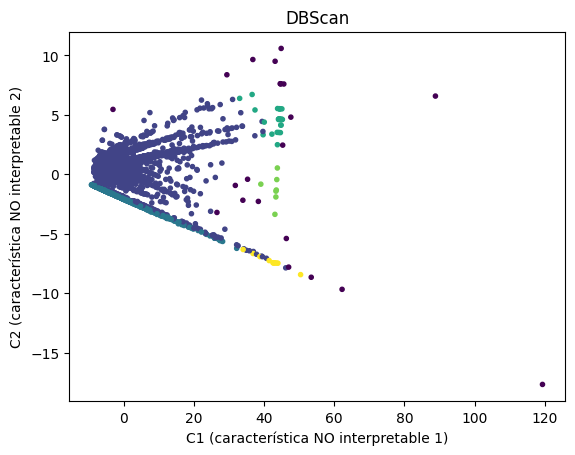

In [ ]:
show_results(df, pred, outliers=True)

Eliminemos los _outliers_ para ver mejor el resultado.

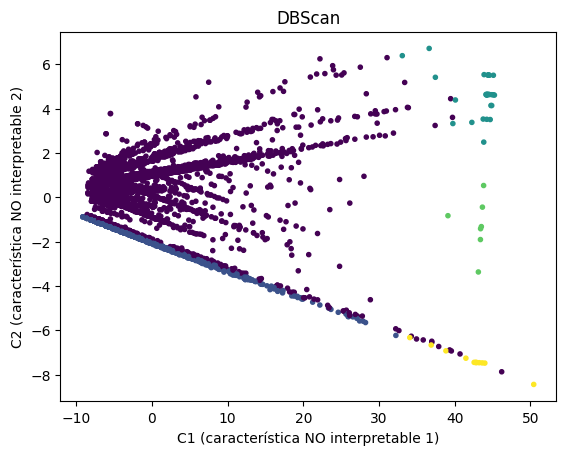

In [ ]:
show_results(df, pred, outliers=False)

¿Cuántos grupos tenemos?

In [ ]:
np.unique(pred)

array([-1,  0,  1,  2,  3,  4])

Tenemos 5 grupos distintos.

**Spoiler**: si hubiésemos quitado la columna ```distance``` tendríamos solo 2.

## Entendiendo los resultados

En este último esquema observamos que existe un grán grupúsculo de usuarios semejantes en Manhattan. Sin embargo encontramos cuatro grupos de usuarios que se comportan de diferente forma.

Hagamos _lupa_. Vamos a buscar quién pertenece a cada grupo y sus características.

In [ ]:
df["cluster"] = pred # volvemos a los datos NO normalizados para poder interpretarlos
df.head()

,distance,fare,tip,payment_isCash,cluster
0,1.60,7.0,2.15,0,0
1,0.79,5.0,0.00,1,1
2,1.37,7.5,2.36,0,0
3,7.70,27.0,6.15,0,0
4,2.16,9.0,1.10,0,0


In [ ]:
df.groupby("cluster").describe().loc[:, (slice(None), ["count", "mean", "max"])]

distance                      fare                        tip  \
           count       mean    max   count       mean     max   count   
cluster                                                                 
-1          22.0  16.341364  28.30    22.0  54.181818  130.00    22.0   
 0        3778.0   2.253801  16.57  3778.0  10.867898   56.74  3778.0   
 1        1377.0   1.909158  12.12  1377.0   9.827524   43.00  1377.0   
 2          28.0  17.218929  20.10    28.0  50.696429   52.00    28.0   
 3           7.0  16.750000  17.10     7.0  51.357143   52.00     7.0   
 4          12.0  17.640000  21.10    12.0  50.958333   59.50    12.0   

                          payment_isCash                 
              mean    max          count      mean  max  
cluster                                                  
-1        9.129545  20.56           22.0  0.045455  1.0  
 0        2.538740  12.26         3778.0  0.000000  0.0  
 1        0.000000   0.00         1377.0  1.000000  1.0  
 2       12.050714  13.26           28.0  0.000000  0.0  
 3        6.085714   8.00            7.0  0.000000  0.0  
 4        0.000000   0.00           12.0  1.000000  1.0

Ignoremos el grupo de los _outliers_ (-1) con 22 casos.

Podemos observar que los grupos 2, 3 y 4 son, realmente, casos particulares de los grupos 0, 0 y 1 respectivamente (la cantidad de elementos en estos grupos es minúscula en comparación con la de los grupos 0 y 1).

En general, la mayoría de personas de Manhattan pagan con tarjeta (grupos 0, 2 y 3; donde el valor máximo de ```payment_isCash``` es 0). De todos ellos, la grandísima mayoría hace trayectos cortos (2 millas), aunque algunos hacen recorridos más largos (hasta 17).
  - En los trayectos cortos (grupo 0), la propina media es de 2.53 dólares (25% aproximadamente del precio total).
  - En los trayectos largos (grupos 2 y 3), la propina depende del grupo. En el grupo 2, tenemos clientes que se comportan como los del grupo 0; en el grupo 3 tenemos clientes que dejan la mitad de propina que los demás.

Para las personas que pagan en efectivo, podemos ver que ninguna de ellas (grupos 1 y 4; trayectos cortos y largos respectivamente) deja propina.

Ahora que hemos extraído esta información, parece claro que si fuesemos un taxista nos gustaría trabajar con clientes de los grupos 0 y 2 (propinas altas). Veamos a qué zonas deberíamos ir con nuestro taxi. Volvemos a unir esta información que habíamos separado al principio en la variable ```pickup_zone```.

In [ ]:
df = pd.concat([df, pd.DataFrame(pickup_zone)], axis=1) # eje X

Aunque todo debería haberse hecho bien, vamos a comprobarlo con la existencia de nulos (**NO** debería haber ninguno, porque los hemos eliminado al principio). Si la función ```concat``` no encuentra el mismo índice, genera valos nulos (esto indicaría algún error).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5224 entries, 0 to 6428
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distance        5224 non-null   float64
 1   fare            5224 non-null   float64
 2   tip             5224 non-null   float64
 3   payment_isCash  5224 non-null   int64  
 4   cluster         5224 non-null   int64  
 5   pickup_zone     5224 non-null   object 
dtypes: float64(3), int64(2), object(1)
memory usage: 285.7+ KB


Como no hay nulos, todo es correcto (hemos asociado cada zona con sus valores iniciales.

Vamos a ver las mejores zonas para el grupo 0.

In [ ]:
golden_df = df[(df.cluster == 0) | (df.cluster == 2)] # los grupos 0 y 2 son los interesantes
golden_df[df.cluster == 0].pickup_zone.unique()

/tmp/ipython-input-2278611373.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  golden_df[df.cluster == 0].pickup_zone.unique()


array(['Lenox Hill West', 'Alphabet City', 'Hudson Sq', 'Midtown East',
       'Times Sq/Theatre District', 'Battery Park City',
       'East Harlem South', 'Lincoln Square East',
       'Upper West Side South', 'Murray Hill', 'Midtown Center',
       'Gramercy', 'East Chelsea', 'Penn Station/Madison Sq West',
       'Sutton Place/Turtle Bay North', 'Clinton East', 'Clinton West',
       'Midtown South', 'Midtown North', 'West Chelsea/Hudson Yards',
       'Garment District', 'Flatiron', 'Upper East Side North',
       'Greenwich Village South', 'East Village', 'Union Sq',
       'UN/Turtle Bay South', 'TriBeCa/Civic Center', 'Yorkville West',
       'Central Park', 'Meatpacking/West Village West', 'Kips Bay',
       'Upper East Side South', 'West Village', 'SoHo', 'Yorkville East',
       'Manhattan Valley', 'Lincoln Square West',
       'Financial District North', 'Lenox Hill East',
       'Little Italy/NoLiTa', 'Morningside Heights', 'East Harlem North',
       'Lower East Side', 'C

Y las del grupo 2.

In [ ]:
golden_df[df.cluster == 2].pickup_zone.unique()

/tmp/ipython-input-4212672985.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  golden_df[df.cluster == 2].pickup_zone.unique()


array(['Midtown South', 'Central Harlem', 'Upper East Side North',
       'Battery Park City', 'UN/Turtle Bay South',
       'Times Sq/Theatre District', 'Midtown East', 'Midtown Center',
       'Sutton Place/Turtle Bay North', 'Lenox Hill East',
       'Lower East Side', 'Union Sq', 'Clinton East', 'Clinton West',
       'Flatiron', 'Bloomingdale', 'Upper West Side North', 'Murray Hill',
       'Financial District South', 'Upper West Side South',
       'Garment District', 'Meatpacking/West Village West'], dtype=object)

Y las que están en ambos.

In [ ]:
c0 = set(golden_df[df.cluster == 0].pickup_zone.unique())
c2 = set(golden_df[df.cluster == 2].pickup_zone.unique())

/tmp/ipython-input-1676258371.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c0 = set(golden_df[df.cluster == 0].pickup_zone.unique())
/tmp/ipython-input-1676258371.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c2 = set(golden_df[df.cluster == 2].pickup_zone.unique())


Si yo fuese un taxista, iría a estas zonas.

In [ ]:
best_zone = c0.intersection(c2)
best_zone

{'Battery Park City',
 'Bloomingdale',
 'Central Harlem',
 'Clinton East',
 'Clinton West',
 'Financial District South',
 'Flatiron',
 'Garment District',
 'Lenox Hill East',
 'Lower East Side',
 'Meatpacking/West Village West',
 'Midtown Center',
 'Midtown East',
 'Midtown South',
 'Murray Hill',
 'Sutton Place/Turtle Bay North',
 'Times Sq/Theatre District',
 'UN/Turtle Bay South',
 'Union Sq',
 'Upper East Side North',
 'Upper West Side North',
 'Upper West Side South'}

Siempre y cuando no estuviesen en las zonas de los que no pagan propina (porque entonces habría probabilidad de recoger a un cliente que no deje propina).

In [ ]:
c1 = set(golden_df[df.cluster == 1].pickup_zone.unique())
c4 = set(golden_df[df.cluster == 4].pickup_zone.unique())

/tmp/ipython-input-3442652597.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c1 = set(golden_df[df.cluster == 1].pickup_zone.unique())
/tmp/ipython-input-3442652597.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c4 = set(golden_df[df.cluster == 4].pickup_zone.unique())


In [ ]:
best_zone.difference(c1).difference(c4)

{'Battery Park City',
 'Bloomingdale',
 'Central Harlem',
 'Clinton East',
 'Clinton West',
 'Financial District South',
 'Flatiron',
 'Garment District',
 'Lenox Hill East',
 'Lower East Side',
 'Meatpacking/West Village West',
 'Midtown Center',
 'Midtown East',
 'Midtown South',
 'Murray Hill',
 'Sutton Place/Turtle Bay North',
 'Times Sq/Theatre District',
 'UN/Turtle Bay South',
 'Union Sq',
 'Upper East Side North',
 'Upper West Side North',
 'Upper West Side South'}

# Resumen

Durante este cuadernillo hemos aprendido cómo utilizar el modelo de _DBSCAN_. Este modelo de aprendizaje **NO** supervisado es el último que veremos este curso, pero esto no significa que no haya más. Puedes investigar por tu cuenta si te gusta este mundillo.

Hemos elegido un conjunto de datos, como _taxis_, que nos ha dado bastante juego.

También hemos definido una función que nos permitía ver distintos resultados para **NO** duplicar código, esto es una buena praxis.

Hemos optimizado nuestro modelo, cometiendo un fallo de sobreajuste y reajustando nuestra métrica para obtener mejores resultados.

Hemos interpretado nuestros resultados y, ahora, podríamos contactar con taxistas para venderles nuestra información. Básicamente, hemos analizado la información que teníamos para determinar las mejores zonas de esta ciudad para ser taxista.

En general, hemos detectado ciertas anomalías (propinas altas) y las hemos utilizado a nuestro favor. Ten en cuenta que esta estrategia puede utilizarse en muchos otros campos, como por ejemplo la detección de tráfico no deseado en una red (grupos pequeños y alejados de _cómo se suele trabajar en la web_) entre otros.

A partir del siguiente cuadernillo, nos sumergiremos en el vasto mundo del aprendizaje supervisado.